# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [14]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

import importlib
importlib.reload(bu)
importlib.reload(gsd)
importlib.reload(gid)
importlib.reload(ssd)
print('Modules reloaded.')

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [15]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [16]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores expandidos com foco em menores amplitudes)
K_GRID = {
    'OR': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0],      # Inner race (Pista Interna)
    'B':  [0.005, 0.01, 0.02, 0.03, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [17]:
sys.path.append(os.path.abspath('src'))
from general_sam_analysis_utils import (
    calcular_sam_graus,
    get_mag_spectrum,
    get_real_signals_metadata_batch,
    get_normal_signal,
    pad_or_trim,
    apply_antialiasing_filter,
    apply_hanning_window,
    limit_spectrum_frequency
)

# Obs.: a geração do sinal por impulso agora vem de `generate_impulse_data.py` (importado como `gid`).

## 3. Execução da Análise
Geração e Comparação para todas as falhas.

In [18]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K)\n

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

FREQ_MAX_VALUES = [200, 600, 800, 1000, 1200]

print("Iniciando sweep de parâmetros para SAM...\n")

# --- Calcular Frequências Naturais do Rolamento (Uma vez) ---
nat_freqs_df = bu.get_bearing_natural_frequencies()

for freq_max in FREQ_MAX_VALUES:
    UPPER_FREQ_LIMIT = freq_max
    print(f"\n--- Iniciando análise para Limite Superior de Frequência: {UPPER_FREQ_LIMIT} Hz ---")

    for rpm in RPMS:
        # Ruído de fundo (Normal) para este RPM
        sinal_normal = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)

        # Calcular frequências características para Limite Inferior
        t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
        t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
        t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
        
        bpfi = t_inner['frequencies']['defect_freq_hz']
        bpfo = t_outer['frequencies']['defect_freq_hz']
        bsf  = t_ball['frequencies']['defect_freq_hz'] 
        ftf  = t_inner['frequencies']['cage_freq_hz']

        # Limite Inferior: 0.8 * min(todas as freq falha + gaiola)
        min_char_freq = min(bpfi, bpfo, bsf)
        LOWER_FREQ_LIMIT = 0.9 * min_char_freq

        # Pre-calcular eixo de frequências
        freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]

        for diam_mm in DIAMETERS_MM:
            for nome, type_code, gen_type in falhas:
                # Grade de K dependente do tipo de falha
                for k_val in K_GRID[type_code]:
                    # 1. Obter Sinais Reais de Referência
                    refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                    num_refs = len(refs)

                    # 2. Calcular Frequência de Falha (para Impulso)
                    tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                    char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                    # --- Método A: Tandon (FFT -> Tempo) ---
                    try:
                        sig_fft_pure, sig_fft_final = gsd.gerar_sinal_tandon_completo(
                            fs=FS,
                            n_points=N_POINTS,
                            diametro_mm=diam_mm,
                            rpm=rpm,
                            tipo_falha=nome,
                            k_val=k_val,
                            sinal_normal=sinal_normal,
                        )
                        # APLICAR FILTROS
                        sig_fft_final = apply_antialiasing_filter(sig_fft_final, FS)
                        sig_fft_final_win = apply_hanning_window(sig_fft_final)
                    except Exception as e:
                        print(f"[Erro Tandon FFT Gen] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                        sig_fft_final_win = np.zeros(N_POINTS)

                    # --- Método B: Impulse Model ---
                    try:
                        sig_imp_pure = gid.gerar_sinal_impulso_completo(
                            fs=FS,
                            duration_points=N_POINTS,
                            defect_freq_hz=char_freq,
                            tipo_falha_str=nome,
                        )
                        sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                        # APLICAR FILTROS
                        sig_imp_final = apply_antialiasing_filter(sig_imp_final, FS)
                        sig_imp_final_win = apply_hanning_window(sig_imp_final)
                    except Exception as e:
                        print(f"[Erro Impulso] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                        sig_imp_final_win = np.zeros(N_POINTS)

                    # 3. Calcular SAM e registrar resultados
                    sam_fft_vals = []
                    sam_imp_vals = []

                    spec_syn_fft_full = get_mag_spectrum(sig_fft_final_win)
                    spec_syn_imp_full = get_mag_spectrum(sig_imp_final_win)

                    # LIMITAR ESPECTRO
                    freqs_lim, spec_syn_fft_lim = limit_spectrum_frequency(freq_axis, spec_syn_fft_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                    _, spec_syn_imp_lim = limit_spectrum_frequency(freq_axis, spec_syn_imp_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                    for _, sig_real in refs:
                        # Filtros no real
                        sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                        sig_real_win = apply_hanning_window(sig_real_filt)
                        spec_real_full = get_mag_spectrum(sig_real_win)
                        _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                        sam_fft_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_fft_lim))
                        sam_imp_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_imp_lim))

                    if sam_fft_vals:
                        mean_fft = float(np.mean(sam_fft_vals))
                        std_fft = float(np.std(sam_fft_vals))
                    else:
                        mean_fft, std_fft = np.nan, np.nan

                    if sam_imp_vals:
                        mean_imp = float(np.mean(sam_imp_vals))
                        std_imp = float(np.std(sam_imp_vals))
                    else:
                        mean_imp, std_imp = np.nan, np.nan

                    dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'fft',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_fft,
                        'sam_std_deg': std_fft
                    })

                    results.append({
                        'rpm': rpm,
                        'diameter_mm': diam_mm,
                        'diameter_label': dia_label,
                        'fault_name': nome,
                        'fault_code': type_code,
                        'freq_max': freq_max,
                        'method': 'impulse',
                        'k': k_val,
                        'num_refs': num_refs,
                        'sam_mean_deg': mean_imp,
                        'sam_std_deg': std_imp
                    })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print("Sweep concluído. Total de linhas em results_df:", len(results_df))
results_df.head()


Iniciando sweep de parâmetros para SAM...


--- Iniciando análise para Limite Superior de Frequência: 200 Hz ---

--- Iniciando análise para Limite Superior de Frequência: 600 Hz ---

--- Iniciando análise para Limite Superior de Frequência: 800 Hz ---

--- Iniciando análise para Limite Superior de Frequência: 1000 Hz ---

--- Iniciando análise para Limite Superior de Frequência: 1200 Hz ---
Sweep concluído. Total de linhas em results_df: 3520


,rpm,diameter_mm,diameter_label,fault_name,fault_code,freq_max,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,200,fft,0.001,20,47.551696,3.079007
1,1730,0.1778,"0.007""",Pista Externa,OR,200,impulse,0.001,20,47.542972,3.078565
2,1730,0.1778,"0.007""",Pista Externa,OR,200,fft,0.002,20,49.097456,2.629987
3,1730,0.1778,"0.007""",Pista Externa,OR,200,impulse,0.002,20,49.079798,2.628618
4,1730,0.1778,"0.007""",Pista Externa,OR,200,fft,0.005,20,49.777667,2.127030


## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


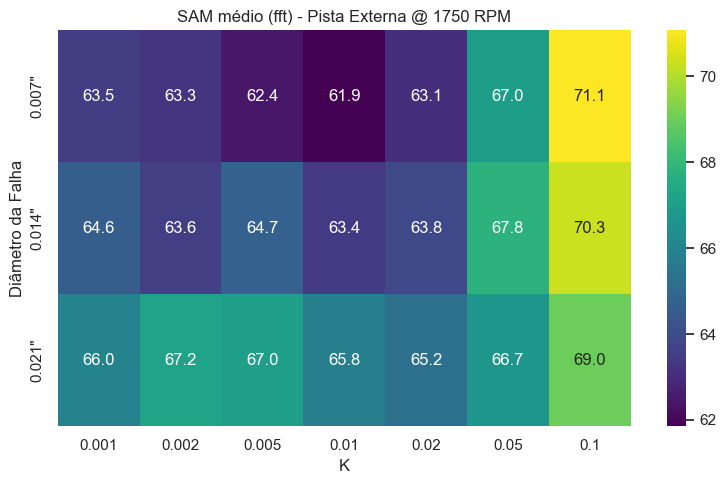

In [19]:
import seaborn as sns

# Garantir estilo
sns.set(style="whitegrid")

# Exemplo: heatmap para um RPM específico e um tipo de falha
rpm_plot = 1750
fault_plot = 'Pista Externa'
method_plot = 'fft'  # ou 'impulse'

subset = results_df[(results_df['rpm'] == rpm_plot) &
                    (results_df['fault_name'] == fault_plot) &
                    (results_df['method'] == method_plot)]

if subset.empty:
    print(f"Nenhum dado em results_df para RPM={rpm_plot}, falha='{fault_plot}', método='{method_plot}'.")
else:
    pivot = subset.pivot_table(index='diameter_label', columns='k', values='sam_mean_deg', aggfunc='mean')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='viridis')
    plt.title(f'SAM médio ({method_plot}) - {fault_plot} @ {rpm_plot} RPM')
    plt.xlabel('K')
    plt.ylabel('Diâmetro da Falha')
    plt.tight_layout()
    plt.show()



Análise das melhores configurações (Menor SAM) variando Freq Máxima



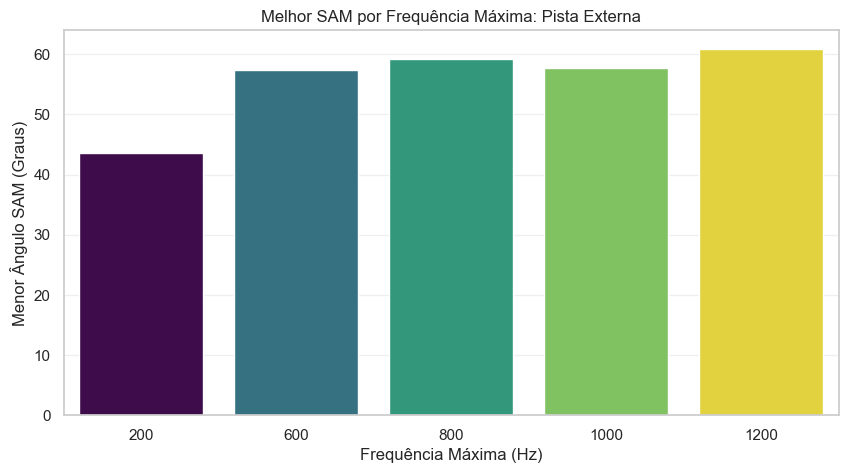

--- Detalhes das Melhores Configurações para Pista Externa ---


,freq_max,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
99,200,1730,"0.021""",impulse,0.05,43.594884,3.032050
761,600,1730,"0.014""",impulse,0.10,57.434955,1.577964
1460,800,1730,"0.014""",fft,0.02,59.233068,1.638528
2164,1000,1730,"0.014""",fft,0.02,57.695932,0.845138
2870,1200,1730,"0.014""",fft,0.05,60.926639,2.955755


--------------------------------------------------------------------------------


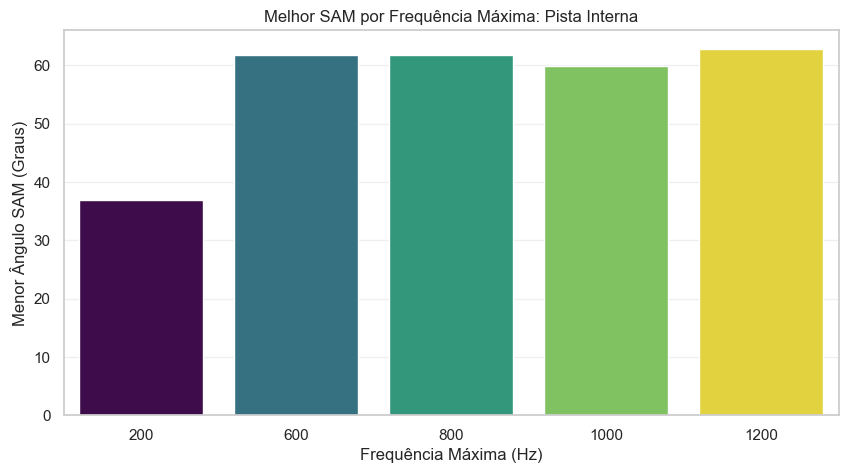

--- Detalhes das Melhores Configurações para Pista Interna ---


,freq_max,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
75,200,1730,"0.014""",impulse,1.00,36.942546,8.965935
730,600,1730,"0.007""",fft,0.50,61.706087,3.255378
1998,800,1797,"0.014""",fft,0.05,61.739518,5.908196
2705,1000,1797,"0.014""",impulse,0.10,59.835143,6.955349
3367,1200,1797,"0.007""",impulse,0.20,62.862019,9.111680


--------------------------------------------------------------------------------


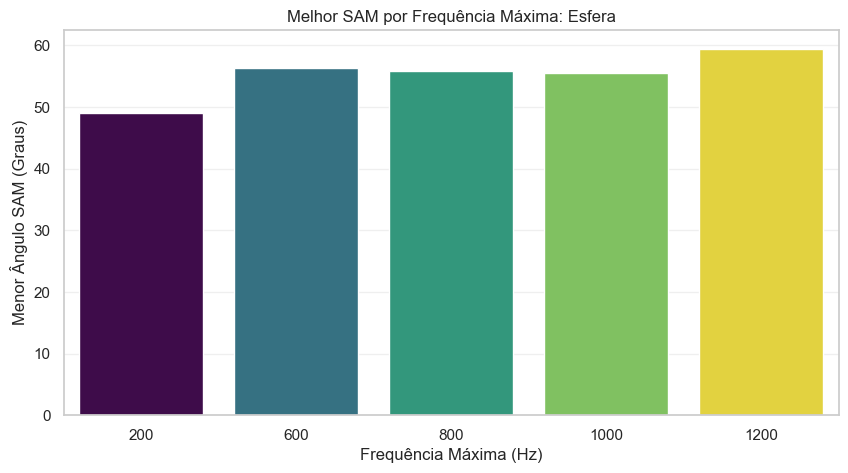

--- Detalhes das Melhores Configurações para Esfera ---


,freq_max,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
84,200,1730,"0.014""",fft,0.05,49.022885,2.150266
1274,600,1797,"0.007""",fft,0.08,56.357399,3.354944
1974,800,1797,"0.007""",fft,0.03,55.796132,2.524555
2681,1000,1797,"0.007""",impulse,0.05,55.508011,2.470582
3211,1200,1772,"0.007""",impulse,0.08,59.474379,4.396748


--------------------------------------------------------------------------------


In [20]:
# 5. Visualização das Melhores Configurações por Freq Máxima e por Falha\n

print("Análise das melhores configurações (Menor SAM) variando Freq Máxima\n")

if 'freq_max' not in results_df.columns:
    print("A coluna 'freq_max' não foi encontrada no DataFrame. Verifique se o loop de Frequência foi executado corretamente.")
else:
    unique_faults = results_df['fault_name'].unique()
    
    for fault in unique_faults:
        # Filtrar por defeito
        df_fault = results_df[results_df['fault_name'] == fault].copy()
        df_fault = df_fault.dropna(subset=['sam_mean_deg'])
        
        if df_fault.empty:
            print(f"Sem dados válidos para {fault}")
            continue

        # Encontrar o menor SAM para cada freq_max
        best_indices = df_fault.groupby('freq_max')['sam_mean_deg'].idxmin()
        best_per_freq = df_fault.loc[best_indices].sort_values(by='freq_max')
        
        # Plot
        plt.figure(figsize=(10, 5))
        
        # Label ex: "fft | 0.007" | K=0.1"
        best_per_freq['label'] = best_per_freq.apply(
            lambda x: f"{x['method']} | Dia:{x['diameter_label']} | K={x['k']} | {x['rpm']} RPM", 
            axis=1
        )
        
        sns.barplot(data=best_per_freq, x='freq_max', y='sam_mean_deg', hue='freq_max', palette='viridis', legend=False)
        
        plt.xlabel('Frequência Máxima (Hz)')
        plt.ylabel('Menor Ângulo SAM (Graus)')
        plt.title(f'Melhor SAM por Frequência Máxima: {fault}')
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()
        
        print(f"--- Detalhes das Melhores Configurações para {fault} ---")
        display(best_per_freq[['freq_max', 'rpm', 'diameter_label', 'method', 'k', 'sam_mean_deg', 'sam_std_deg']])
        print("-" * 80)
